In [116]:
import requests
import numpy as np
import matplotlib.pyplot as plt


In [155]:
FILE = 'temp.mol'
with open(FILE, 'r+') as f:
    content = f.readlines()
print(content)
content = ''.join(content)

payload = {'molfile' : content}
print(payload)

response = requests.post('http://localhost:8091/v1/fromMolfile', json=payload).json()


['\n', '     RDKit          3D\n', '\n', ' 18 17  0  0  0  0  0  0  0  0999 V2000\n', '    2.4559   -0.0840   -0.0874 C   0  0  0  0  0  0  0  0  0  0  0  0\n', '    1.0946    0.4004    0.3313 C   0  0  0  0  0  0  0  0  0  0  0  0\n', '    0.1256   -0.7470    0.2526 C   0  0  0  0  0  0  0  0  0  0  0  0\n', '   -1.2735   -0.3301    0.6624 C   0  0  0  0  0  0  0  0  0  0  0  0\n', '   -1.8205    0.7556   -0.2056 C   0  0  0  0  0  0  0  0  0  0  0  0\n', '   -1.8759    0.3168   -1.5387 O   0  0  0  0  0  0  0  0  0  0  0  0\n', '    2.3380   -0.6606   -1.0453 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    3.1374    0.7672   -0.2496 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    2.8971   -0.7844    0.6804 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    0.8229    1.2425   -0.3173 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    1.2001    0.7915    1.3713 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    0.4556   -1.5506    0.9423 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    0.1493   

{'x': {'label': 'Binding Enegies', 'data': [288.1485466651502, 288.40047849972535, 288.6524103343005, 288.90434216887564, 289.15627400345085, 289.408205838026, 289.66013767260114, 289.9120695071763, 290.16400134175143, 290.4159331763266, 290.6678650109018, 290.9197968454769, 291.17172868005207, 291.4236605146272, 291.67559234920236, 291.9275241837775, 292.1794560183527, 292.43138785292786, 292.683319687503, 292.93525152207815, 293.1871833566533, 293.43911519122844, 293.6910470258036, 293.9429788603788, 294.19491069495393, 294.4468425295291, 294.6987743641042, 294.95070619867937, 295.2026380332545, 295.4545698678297, 295.70650170240486, 295.95843353698, 296.21036537155516, 296.4622972061303, 296.71422904070545, 296.9661608752806, 297.2180927098558, 297.47002454443094, 297.7219563790061, 297.97388821358123, 298.2258200481564, 298.4777518827315, 298.7296837173067, 298.9816155518819, 299.233547386457, 299.48547922103216, 299.7374110556073, 299.98934289018246, 300.24127472475766, 300.493206

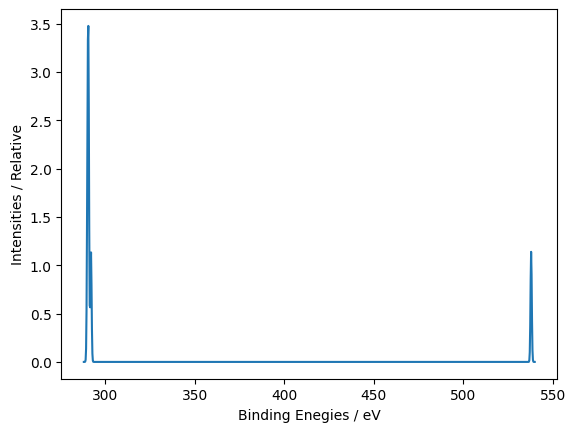

In [156]:
def plot_spectrum(json_response):
    fig, ax = plt.subplots(1,1)
    spectrum = json_response['spectrum']['gaussian']
    print(spectrum)
    x, y = spectrum['x'], spectrum['y']
    ax.plot(x['data'], y['data'])
    ax.set_xlabel(f"{x['label']} / {x['units']}")
    ax.set_ylabel(f"{y['label']} / {y['units']}")
plot_spectrum(response)

In [7]:
def plot_val(values, sigma, plot = True):
    def g(BE_sweep, BE_max, σ):
        G = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(BE_sweep-BE_max)**2 / (2*sigma**2))
        new_y= np.array(G)
        return new_y

    # Calculate mean and standard deviation
    mean = np.mean(values)
    std_dev = np.std(values)
    # Create a range of x values for the plot
    x = np.linspace(min(values) - 2, max(values) + 2, 1000)

    # Plot Gaussian curves for each center value
    #plt.figure(figsize=(8, 6))
    gaussian=0
    for val in values:
        gaussian += g(x,val,sigma)
    return x, gaussian

x,y = plot_val(BEs, 0.35)

NameError: name 'BEs' is not defined

(289.0, 294.0)

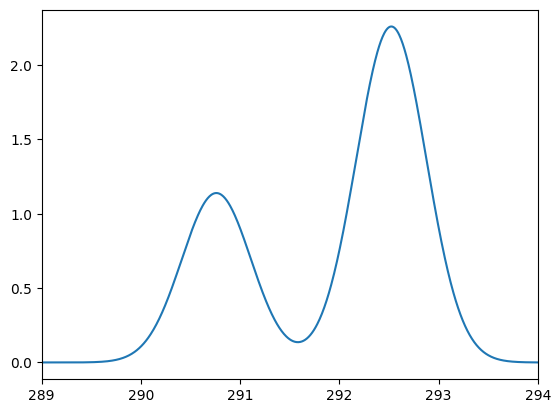

In [ ]:
plt.plot(x,y)
plt.xlim(289, 294)

In [107]:
from rdkit import Chem
from rdkit.Chem import AllChem

from ase.io import read
from quippy.descriptors import Descriptor

import logging
import pickle

import os

MODEL = '../MLmodels/XPS_GPR_C1s.pkl'

# First we create the descriptor object

Z = 6 
cutoff = 5; dc = 0.5; sigma = 0.5
zeta = 6
SOAP = {"C": 'soap_turbo alpha_max={8 8 8} l_max=8 rcut_soft=%.4f rcut_hard=%.4f atom_sigma_r={%.4f %.4f %.4f} atom_sigma_t={%.4f %.4f %.4f} \
               atom_sigma_r_scaling={0. 0. 0.} atom_sigma_t_scaling={0. 0. 0.} radial_enhancement=1 amplitude_scaling={1. 1. 1.} \
               basis="poly3gauss" scaling_mode="polynomial" species_Z={1 6 8} n_species=3 central_index=2 central_weight={1. 1. 1.} \
               compress_mode=trivial' % (cutoff-dc, cutoff, *(6*[sigma])),
        "O": 'soap_turbo alpha_max={8 8 8} l_max=8 rcut_soft=%.4f rcut_hard=%.4f atom_sigma_r={%.4f %.4f %.4f} atom_sigma_t={%.4f %.4f %.4f} \
               atom_sigma_r_scaling={0. 0. 0.} atom_sigma_t_scaling={0. 0. 0.} radial_enhancement=1 amplitude_scaling={1. 1. 1.} \
               basis="poly3gauss" scaling_mode="polynomial" species_Z={1 6 8} n_species=3 central_index=3 central_weight={1. 1. 1.} \
               compress_mode=trivial' % (cutoff-dc, cutoff, *(6*[sigma]))}

from pydantic import BaseModel, Field, validator
from typing import Dict, List, Optional

class soap(BaseModel):
    element: str
    descriptor: str
    data: List

class bindingEnergyPrediction(BaseModel):
    modelFile: str
    model: Dict
    data: List
    standardDeviation: List

class SpectralData(BaseModel):
    label: str = Field(None, description="Label of axis")
    data: List[float] = Field(None, description="Data of axis")
    units: str = Field(None, description="Unit of axis")

class ModelPrediction(BaseModel):
    element: str
    soapTurbo: soap
    prediction: bindingEnergyPrediction

class SpectrumData(BaseModel):
    x: SpectralData
    y: SpectralData
    
class PredictedXPSSpectrum(BaseModel):
    bindingEnergies: List[float]
    spectrum: SpectrumData
    sigma: float = Field(None, description= "Sigma used for Gaussians")

class FullPrediction(BaseModel):
    molfile: str
    bindingEnergies: List[ModelPrediction]
    spectrum: PredictedXPSSpectrum



def xyz_to_soap_turbo(mol, element):

    desriptor =Descriptor(SOAP[element])

    atoms = []
    if (element in mol.symbols) == True:
        descMol = desriptor.calc(mol) #descriptor for each atom

        if 'data' in descMol:
           desc_data = descMol['data'] #get the data from the descriptor object if exist
           for atom in desc_data:
               atoms.append(atom)
        return soap(
            element = element,
            descriptor = SOAP[element],
            data = atoms
        )
    
    else:
        logging.info(f'Element "{element}" not in molecule')
        return []
    

def molfile_to_xyz(molfile:str):
    logging.info('molfile to xyz')
    temp_file = 'temp2.mol'
    with open(temp_file, 'w+') as f:
        f.write(molfile) #write molfile to temporary file
    mol = Chem.MolFromMolFile(temp_file) # Read temp file into RDKit molecule
    mol = Chem.AddHs(mol)# post-process molecule
    AllChem.EmbedMolecule(mol)
    Chem.MolToMolFile(mol, temp_file)    # Write RDKit molecule to a temporary file
    molecule = read(temp_file) # Read the temporary file into ASE Atoms object
    return molecule

def smiles_to_xyz(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    Chem.MolToMolFile(mol, 'temp.mol')    # Write RDKit molecule to a temporary file
    molecule = read('temp.mol') # Read the temporary file into ASE Atoms object
    return molecule

def soap_to_BE(soap, element):
    model_file = f'../MLmodels/XPS_GPR_{element}1s.pkl'

    model = pickle.load(open(model_file, 'rb'))
    logging.info('Model loaded')

    be, std = model.predict(soap, return_std = True)
    return bindingEnergy_prediction(
        modelFile = model_file,
        model = model.__dict__, 
        data = list(be),
        standardDeviation = list(std)
    )

def molfile_to_BE(molfile:str):
    bes = []
    not_present = []
    be_predictions = []
    mol = molfile_to_xyz(molfile)

    for element in ['C', 'O']:
        logging.info(element)
        if (element in mol.symbols):
            soaps = xyz_to_soap_turbo(mol, element=element)
            be = soap_to_BE(soaps.data, element)
            for i in be.data:
                bes.append(i)

            model_prediction = ModelPrediction(
                element = element,
                soapTurbo = soaps,
                prediction = be
            )
            be_predictions.append(model_prediction)

        else:
            not_present.append(element)

    return be_predictions

def smiles_to_BE(smiles:str):
    mol = smiles_to_xyz(smiles)
    soaps = xyz_to_soap_turbo(mol, element= 'C')
    be = soap_to_BE(soaps, 'C')
    return be


def get_gaussians(values, sigma, limit = 2):
    def g(BE_sweep, BE_max, sigma_):
        G = 1/(sigma_*np.sqrt(2*np.pi)) * np.exp(-(BE_sweep-BE_max)**2 / (2*sigma_**2))
        new_y= np.array(G)
        return new_y

    # Create a range of x values for the plot
    x = np.linspace(min(values) - limit, max(values) + limit, 1000)
    logging.info(f'n points in spectra = {len(x)}')

    gaussian=0
    for val in values:
        gaussian += g(x,val,sigma)

    return SpectrumData(
        x = SpectralData(
            label = "Binding Enegies",
            data = list(x),
            units = 'eV'
        ),
        y = SpectralData(
            label = "Intensities",
            data = list(gaussian),
            units = 'Relative'
        )
    )

def get_all_BEs(predictions: ModelPrediction):
    all_BE = []
    for pred in predictions:
        for be in pred.prediction.data:
            all_BE.append(be)
    return all_BE



def fromMolfile(molfile:str, sigma = 0.35, limit = 2):
    binding_energies = molfile_to_BE(molfile)
    logging.info(f'Binding Energies OK: n = {len(binding_energies)}')
    all_BEs = get_all_BEs(binding_energies)

    print(all_BEs)
    spectra_gauss  = get_gaussians(all_BEs, sigma, limit = limit)

    return PredictedXPSSpectrum(
        bindingEnergies = all_BEs,
        spectrum = spectra_gauss,
        sigma = sigma
    )

def be_to_spectrum(be:bindingEnergyPrediction, sigma = 0.35, limit = 2):
    all_BEs = get_all_BEs(be)

    spectra_gauss  = get_gaussians(all_BEs, sigma = sigma, limit = limit)

    return PredictedXPSSpectrum(
        bindingEnergies = all_BEs,
        spectrum = spectra_gauss,
        sigma = sigma
    )

def fromSmiles(smiles, sigma = 0.35, limit =2):
    binding_energies = smiles_to_BE(smiles)
    logging.info(f'Binding Energies OK: n = {len(binding_energies)}')
    BEs, intensities  = get_gaussians(binding_energies, sigma, limit = limit)
    return BEs, intensities

def fromMolfile(molfile, sigma = 0.35):
    be = molfile_to_BE(molfile)
    pred_spectrum = be_to_spectrum(molfile, sigma=sigma)


    return FullPrediction(
        molfile = molfile,
        bindingEnergies = be,
        spectrum = pred_spectrum
    )


In [108]:
with open('temp.mol', 'r+') as f:
    content = f.read()
be = fromMolfile(content)

AttributeError: 'str' object has no attribute 'prediction'

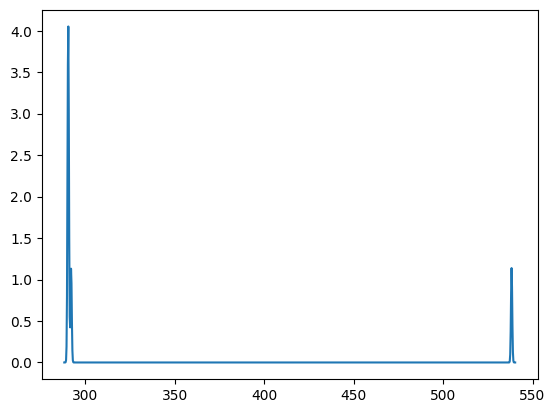

In [95]:
import matplotlib.pyplot as plt

plt.plot(be.spectrum.x.data, be.spectrum.y.data)